In [58]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency, chi2
import statsmodels.api as sm
import plotly.express as px

In [59]:
# national robbery 2012-2022

national_url = f'https://api.usa.gov/crime/fbi/cde/nibrs/national/robbery?from=1-2012&type=Counts&to=12-2022&API_KEY={key}'

response = requests.get(national_url)
if response.status_code == 200:
    national = response.json()
else:
    print(f"Error: {response.status_code}")

In [60]:
national.get('victim').get('location')

{'Rest Area': 732,
 'Cyberspace': 0,
 'Restaurant': 57118,
 'Field/Woods': 8640,
 'Liquor Store': 8745,
 'Tribal Lands': 65,
 'Bar/Nightclub': 9578,
 'Farm Facility': 97,
 'Not Specified': 0,
 'Other/Unknown': 43827,
 'Shopping Mall': 6451,
 'Amusement Park': 290,
 'Residence/Home': 248894,
 'School/College': 1265,
 'Camp/Campground': 379,
 'Industrial Site': 341,
 'Park/Playground': 17848,
 'Specialty Store': 46181,
 'Community Center': 417,
 'Daycare Facility': 116,
 'Hotel/Motel/Etc.': 28167,
 'Construction Site': 1099,
 'Convenience Store': 116176,
 'Grocery/Supermarket': 37216,
 'Lake/Waterway/Beach': 695,
 'Service/Gas Station': 56014,
 'Bank/Savings and Loan': 33768,
 'Military Installation': 8,
 'ATM Separate from Bank': 1312,
 'Air/Bus/Train Terminal': 8508,
 'Parking/Drop Lot/Garage': 128665,
 'Rental Storage Facility': 855,
 'Auto Dealership New/Used': 924,
 'Shelter-Mission/Homeless': 521,
 'Department/Discount Store': 74394,
 'School-College/University': 1634,
 'Commercial

In [61]:
# Maya - work on most robbed locations by state

# california robbery 2012-2022

cali_url = 'https://api.usa.gov/crime/fbi/cde/nibrs/state/CA/robbery?from=1-2012&to=12-2022&API_KEY=' + key

response = requests.get(cali_url)
if response.status_code == 200:
    cali = response.json()
else:
    print(f"Error: {response.status_code}")

In [62]:
crimescene = cali.get('victim').get('location').keys()
crimescene = {}

link1 = cali_url[:46]
link2 = cali_url[48:]

states = ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
          "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
          "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
          "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
          "WV", "WY"]

for state in states:
    link = link1 + state + link2
    response = requests.get(link)
    if response.status_code == 200:
        link = response.json()
        crimescene[f'{state}'] = (pd.Series(link.get('victim').get('location')))
    else:
        print(f"Error: {response.status_code}")

In [63]:
crimescene_df = pd.DataFrame(crimescene).T.fillna(0)
state_colors = crimescene_df.apply('idxmax', axis=1)
state_colors = state_colors.reset_index()
state_colors.columns = ['State', 'MostCommonCrimeScene']

crime_scenes = state_colors['MostCommonCrimeScene'].unique()
color_map = {scene: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
             for i, scene in enumerate(crime_scenes)}

state_colors['Color'] = state_colors['MostCommonCrimeScene'].map(color_map)

In [64]:
state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West',
    'CO': 'West', 'CT': 'Northeast', 'DE': 'South', 'FL': 'South', 'GA': 'South',
    'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'ME': 'Northeast', 'MD': 'South',
    'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest',
    'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest',
    'OK': 'South', 'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South',
    'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West', 'VT': 'Northeast',
    'VA': 'South', 'WA': 'West', 'WV': 'South', 'WI': 'Midwest', 'WY': 'West',
    'DC': 'South'
}

crimescene_df['Region'] = crimescene_df.index.map(state_to_region)
region_df = crimescene_df.groupby('Region').sum()
region_df = region_df.loc[:, region_df.sum() > 500]

chi2, p, dof, expected = chi2_contingency(region_df)
print(f'Chi-Square Statistic: {chi2}')
print(f'p-value: {p}')
print(f'Degrees of Freedom: {dof}')

Chi-Square Statistic: 114782.72961377341
p-value: 0.0
Degrees of Freedom: 99


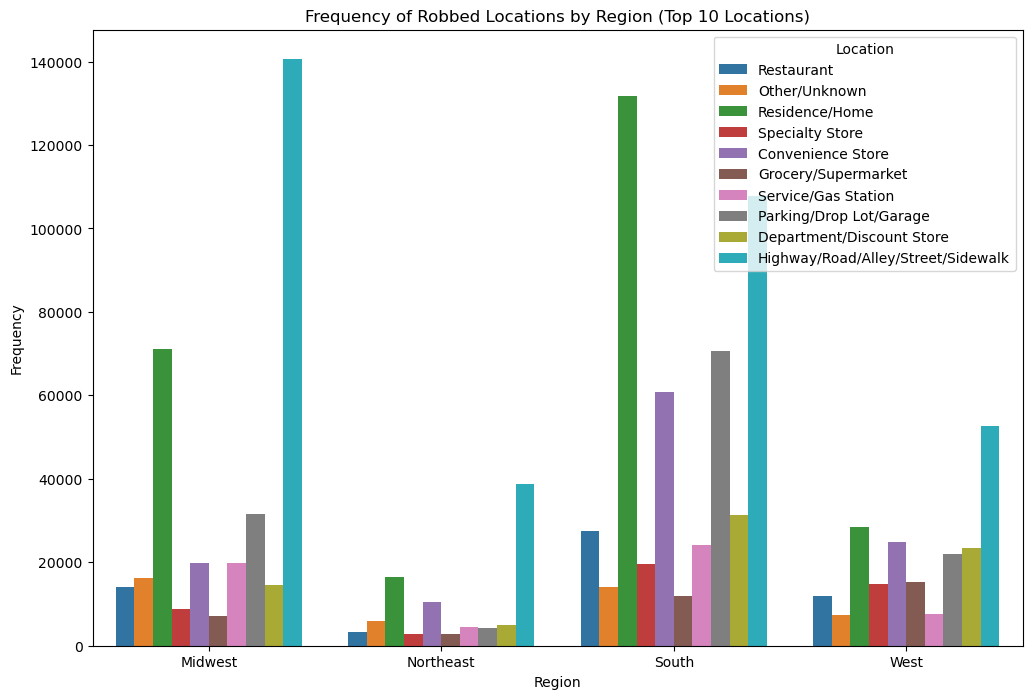

In [65]:
region_df = region_df.reset_index()

long_df = region_df.melt(
    id_vars='Region', var_name='Location', value_name='Frequency')

location_totals = long_df.groupby('Location')['Frequency'].sum()

top_10_locations = location_totals.nlargest(10).index

filtered_df = long_df[long_df['Location'].isin(top_10_locations)]

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_df, x='Region', y='Frequency', hue='Location')
plt.title('Frequency of Robbed Locations by Region (Top 10 Locations)')
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.legend(title='Location', loc='upper right')
plt.show()

In [66]:
state_colors['Color'].unique()

array(['#636EFA', '#EF553B', '#00CC96', '#AB63FA'], dtype=object)

In [67]:
fig = px.choropleth(locations=state_colors['State'],
                    color=state_colors['MostCommonCrimeScene'],
                    locationmode='USA-states',
                    scope='usa',
                    color_discrete_map=dict(
                        zip(crime_scenes, state_colors['Color'].unique())),
                    )

fig.show()

In [68]:
# Indi - work on robbery rate vs law enforcement employees by year

# employees 2012-2022

employees_url  = f'https://api.usa.gov/crime/fbi/cde/pe?from=2012&to=2022&API_KEY={key}'

response = requests.get(employees_url)
if response.status_code == 200:
    employees = response.json()
else:
    print(f"Error: {response.status_code}")

In [69]:
male = employees.get('actuals').get('Male Officers').values()
female = employees.get('actuals').get('Female Officers').values()

In [70]:
per = employees.get('rates').get('Officers per 1,000 People').values()

In [73]:
# national robbery 2012-2022 by year

base_url = 'https://api.usa.gov/crime/fbi/cde/nibrs/national/robbery?from={}&type=Counts&to={}&API_KEY=' + key

rob_by_year = {}

for year in range(2012, 2023):
    url = base_url.format(f'1-{year}', f'12-{year}')
    response = requests.get(url)
    if response.status_code == 200:
        rob_by_year[year] = response.json()
    else:
        print(f"Error: {response.status_code}")


In [74]:
rob_per_year = []

for year in range(2012, 2023):
    rob_per_year.append(
        sum(rob_by_year.get(year).get('victim').get('sex').values()))

employees_df = pd.DataFrame([range(2012, 2023), rob_per_year, male, female, per]).T
employees_df.columns = ['Year', 'Robberies', 'Male_Officers', 'Female_Officers', 'Officers_per_1k']
employees_df.set_index('Year', inplace=True)
employees_df.to_csv('employees.csv')

In [75]:
employees_df = pd.read_csv('employees.csv')

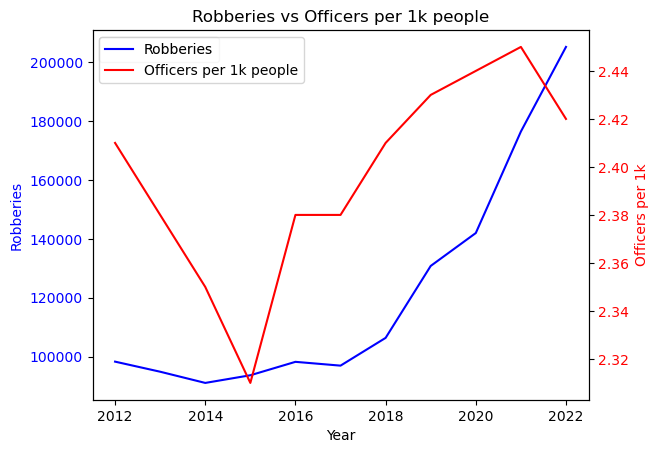

0.6648185233967915


In [76]:
fig, ax1 = plt.subplots()

# Plot the 'Robberies' on the left y-axis
sns.lineplot(data=employees_df, x='Year', y='Robberies',
             ax=ax1, label='Robberies', color='b')
ax1.set_ylabel('Robberies', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the 'Officers_per_1k' on the right y-axis
sns.lineplot(data=employees_df, x='Year', y='Officers_per_1k',
             ax=ax2, label='Officers per 1k people', color='r')
ax2.set_ylabel('Officers per 1k', color='r')
ax2.tick_params(axis='y', labelcolor='r')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')
plt.title('Robberies vs Officers per 1k people')

plt.show()
print(employees_df.Robberies.corr(employees_df.Officers_per_1k))

In [77]:
# national robbery 2012-2022 by month

base_url = 'https://api.usa.gov/crime/fbi/cde/nibrs/national/robbery?from={}&type=Counts&to={}&API_KEY=' + key

rob_month = {}

for year in range(2012, 2023):
    for month in range(1, 13):
        url = base_url.format(f'{month}-{year}', f'{month}-{year}')
        response = requests.get(url)
        if response.status_code == 200:
            rob_month[f'{month}-{year}'] = response.json()
        else:
            print(f"Error: {response.status_code}")

In [99]:
month_list = {}

for year in range(2012, 2023):
    for month in range(1, 13):
        month_list[f'{month}-{year}'] = (pd.Series(rob_month.get(
            f'{month}-{year}').get('offense').get('weapons')))

weapons_df = pd.DataFrame(month_list).T
weapons_df.to_csv('weapons.csv', index_label='Date')

In [13]:
weapons_df = pd.read_csv('weapons.csv')
weapons_df.Date = pd.to_datetime(weapons_df.Date, format='%m-%Y')
weapons_df.set_index('Date', inplace=True)

In [3]:
weapons_df.sum(axis=0).sort_values(ascending=False)

Handgun                            313211
Personal Weapons                   303741
None                                97963
Firearm                             81801
Knife/Cutting Instrument            80929
Other                               40826
Unknown                             34662
Blunt Object                        29678
Handgun (Automatic)                 18331
Rifle                                7848
Shotgun                              6709
Other Firearm                        6571
Motor Vehicle/Vessel                 5196
Firearm (Automatic)                  3832
Asphyxiation                         1004
Rifle (Automatic)                     741
Explosives                            591
Poison                                555
Other Firearm (Automatic)             293
Drugs/Narcotics/Sleeping Pills        281
Fire/Incendiary Device                275
Shotgun (Automatic)                    90
Drowning                                0
Unarmed                           

In [14]:
weapons_df['Firearm'] = weapons_df[['Firearm', 'Rifle',
                                    'Handgun', 'Shotgun', 'Other Firearm']].sum(axis=1)
weapons_df.drop(['Rifle', 'Handgun', 'Shotgun',
                'Other Firearm'], axis=1, inplace=True)
weapons_df['Firearm (Automatic)'] = weapons_df[['Rifle (Automatic)', 'Handgun (Automatic)',
                                                'Shotgun (Automatic)', 'Firearm (Automatic)', 'Other Firearm (Automatic)']].sum(axis=1)
weapons_df.drop(['Rifle (Automatic)', 'Handgun (Automatic)',
                'Shotgun (Automatic)', 'Other Firearm (Automatic)'], axis=1, inplace=True)
weapons_df['Unknown'] = weapons_df[['Unknown', 'None']].sum(axis=1)
weapons_df.drop(['None'], axis=1, inplace=True)
weapons_df.drop(['Pushed or Thrown Out Window', 'Unarmed', 'Drowning', 'Lethal Cutting Instrument', 'Club/Blackjack/Brass Knuckles',
                'Strangulation - Include Hanging', 'Drugs/Narcotics/Sleeping Pills', 'Fire/Incendiary Device', 'Poison', 'Explosives'], axis=1, inplace=True)

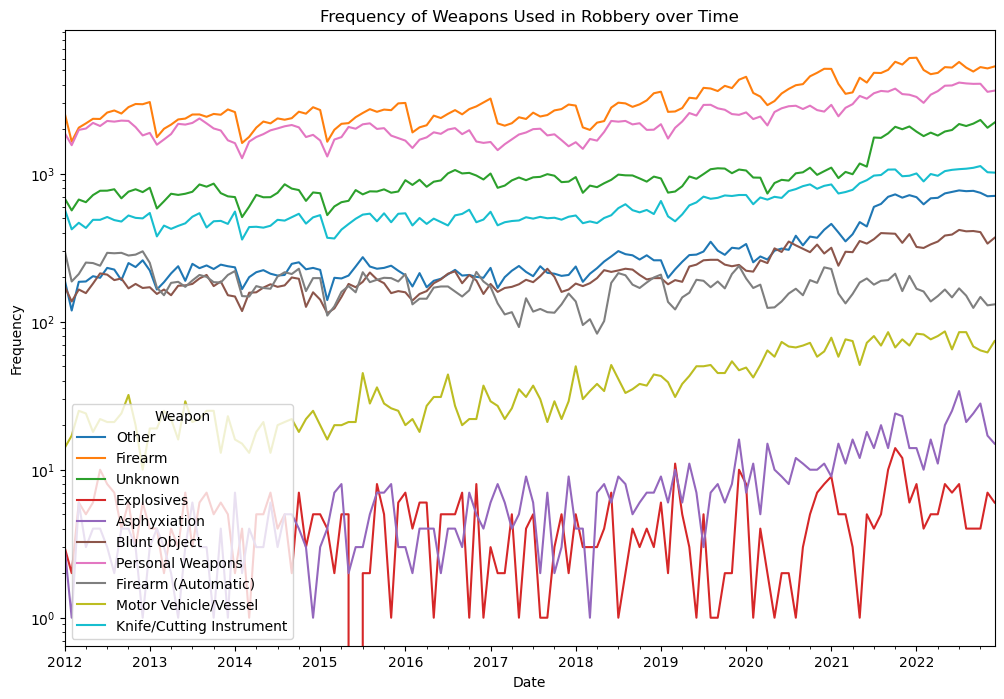

In [10]:
weapons_df.plot(kind='line', figsize=(12, 8))

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of Weapons Used in Robbery over Time')
plt.legend(title='Weapon', loc='lower left')
plt.yscale('log')

plt.show()

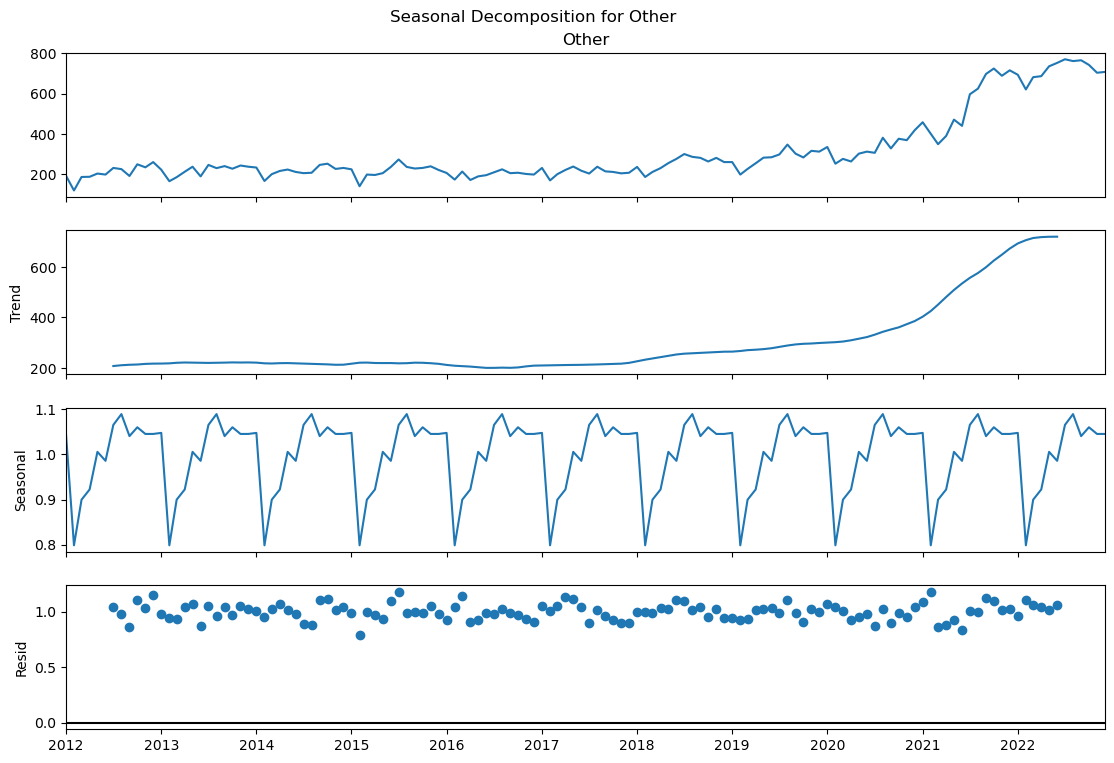

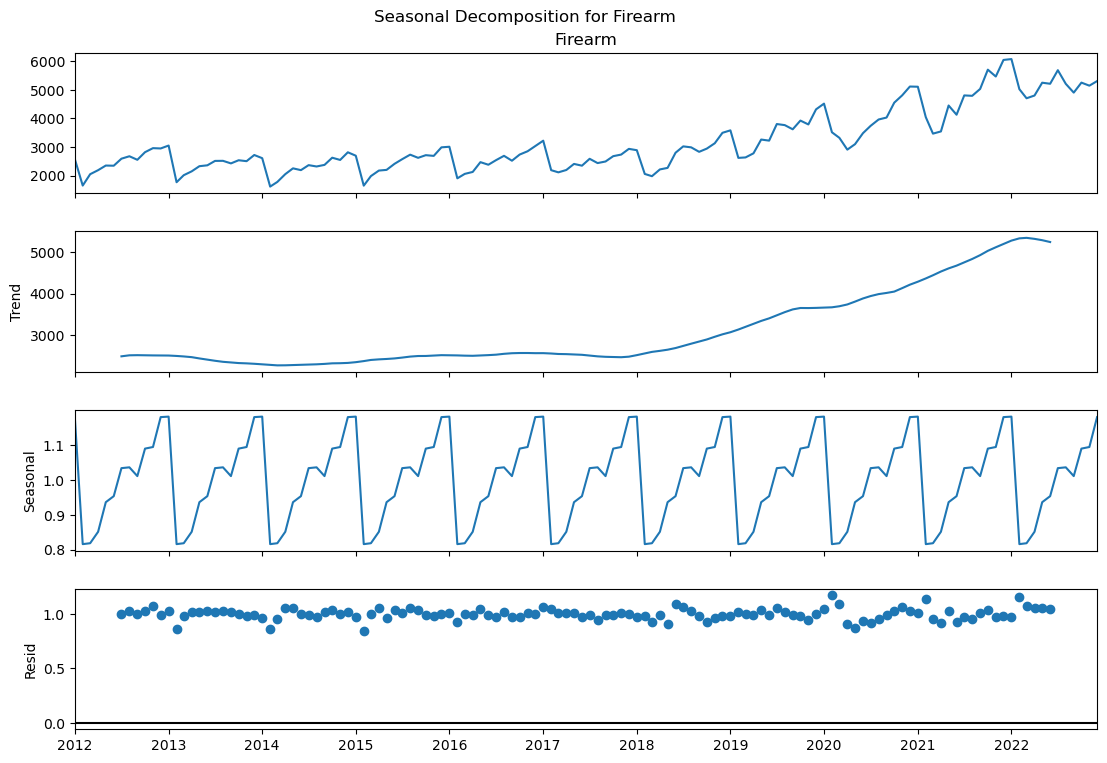

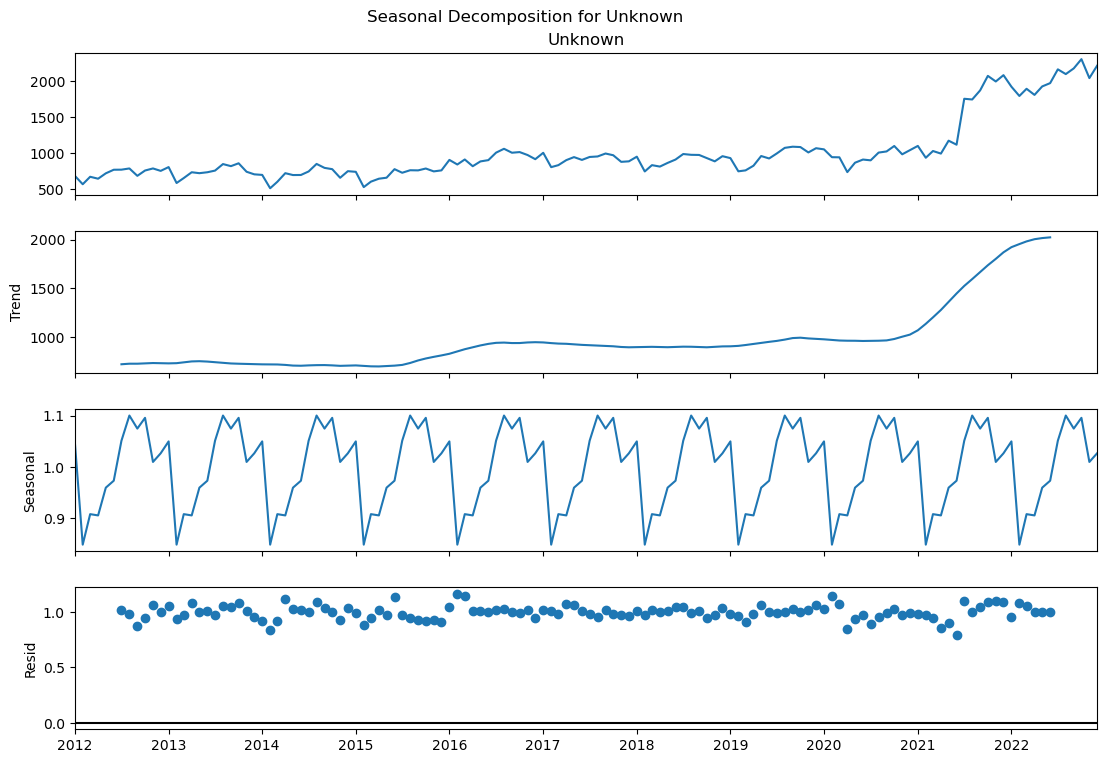

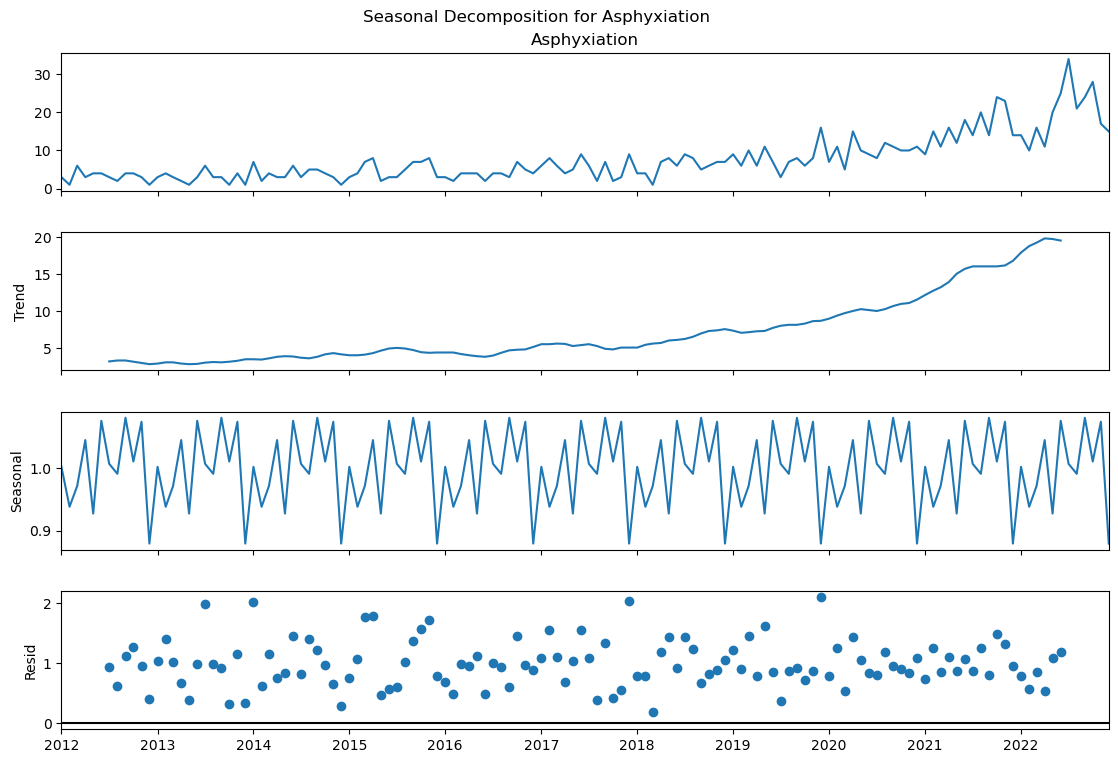

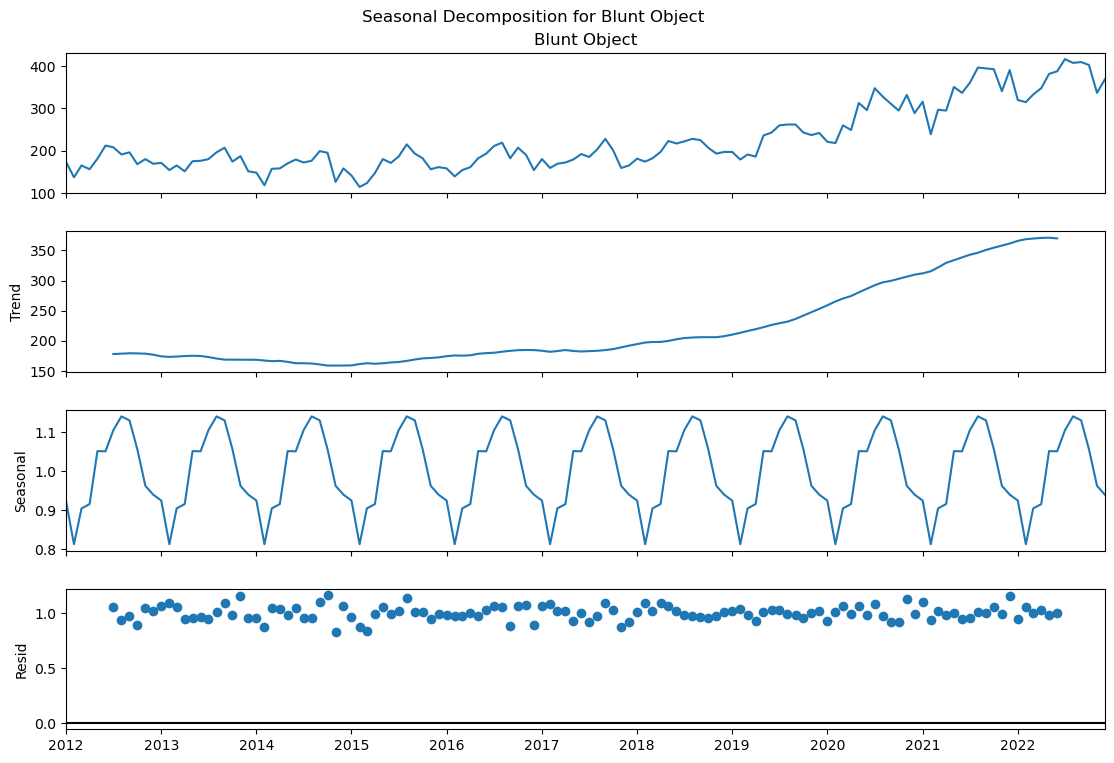

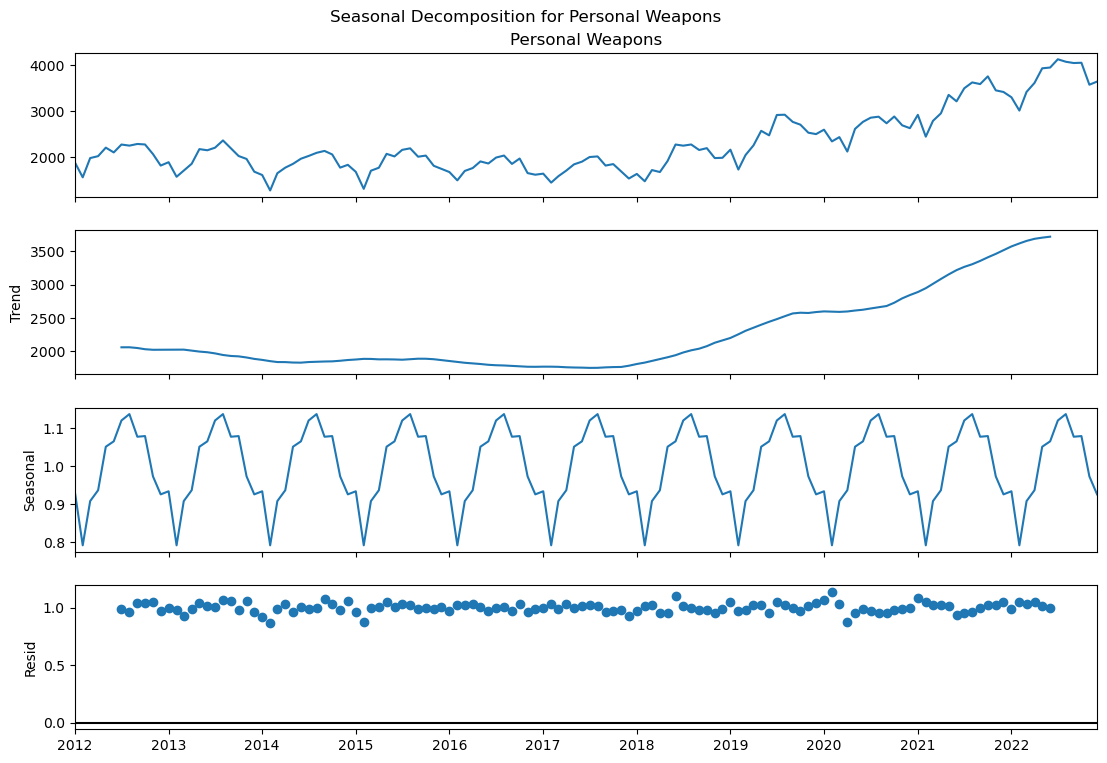

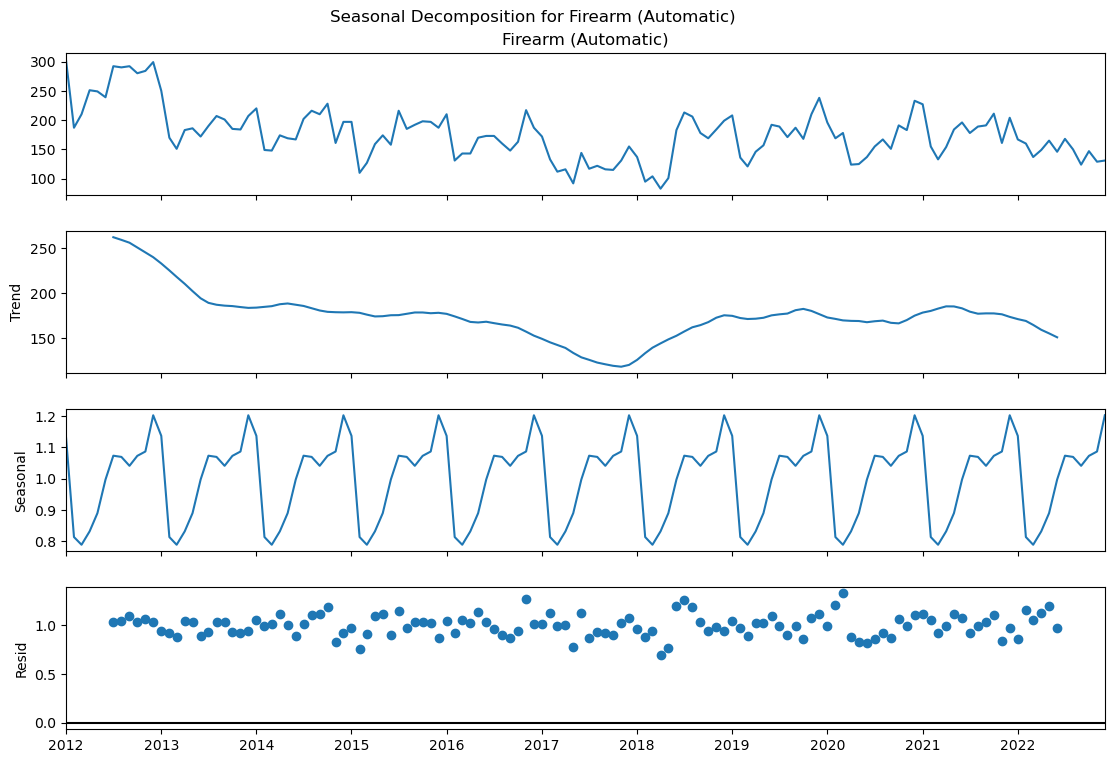

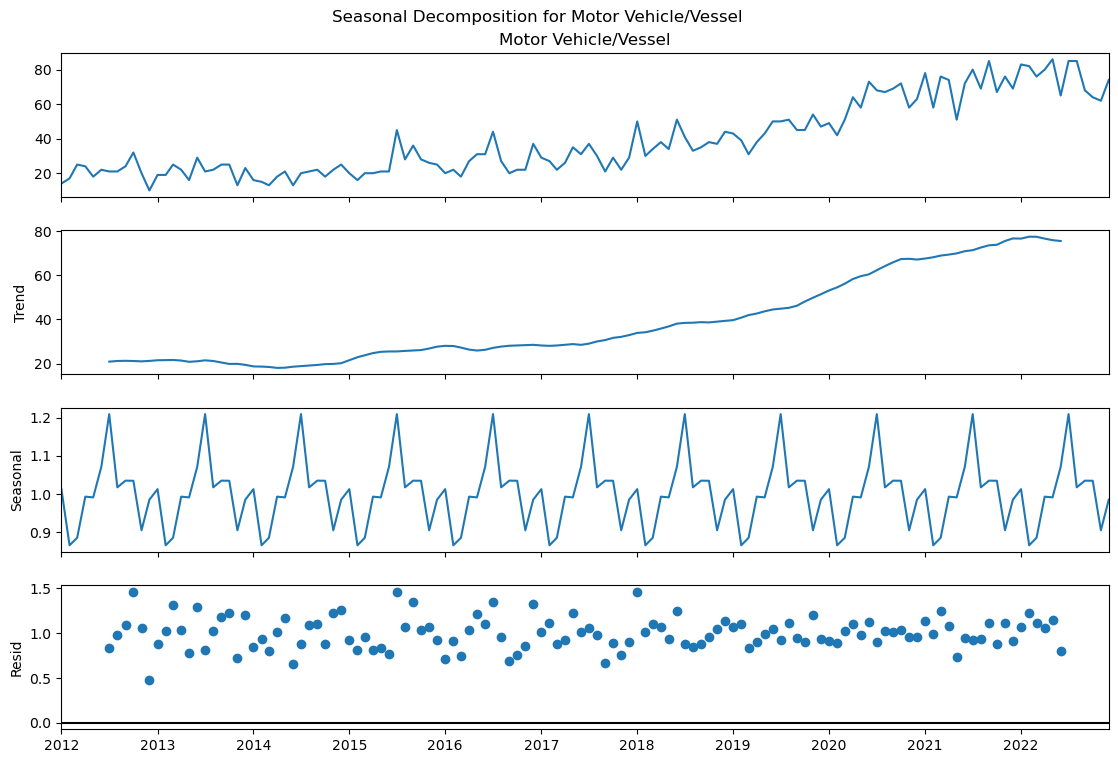

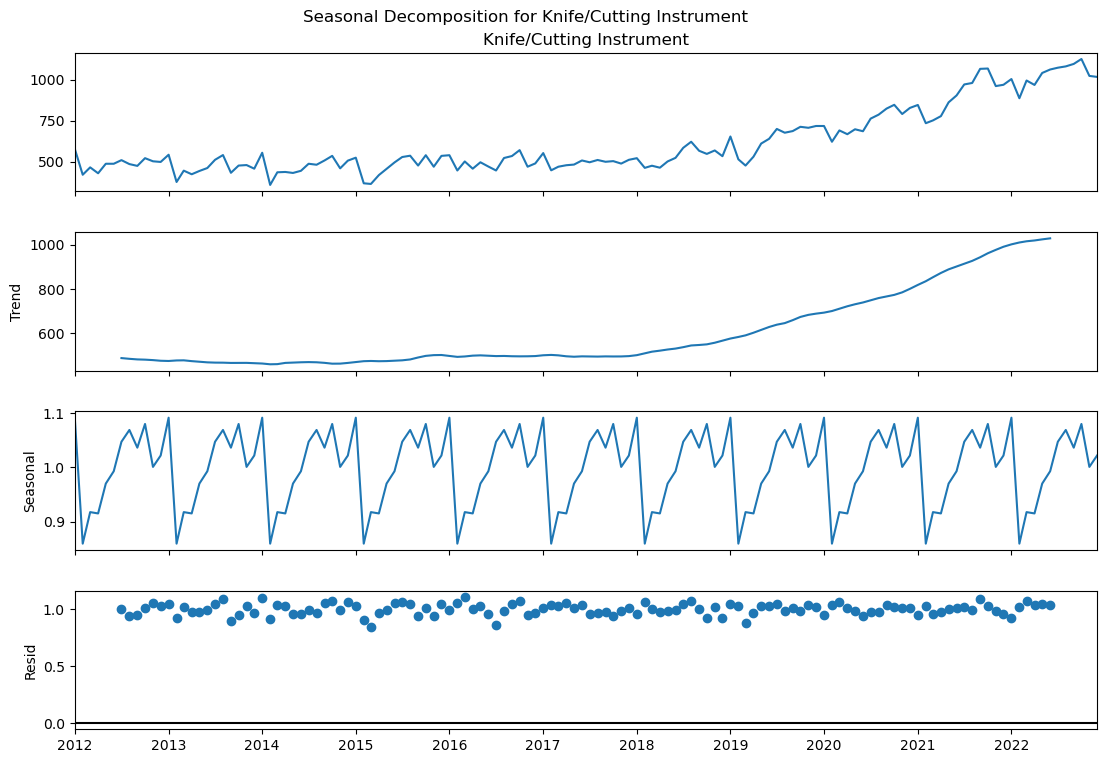

In [16]:
# Decompose the time series
for column in weapons_df.columns:
    decomposition = sm.tsa.seasonal_decompose(
        weapons_df[column], model='multiplicative')

    # Plot the decomposition
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f'Seasonal Decomposition for {column}')
    plt.show()

In [31]:
years = list(range(2012, 2023))
age_30_plus = {year: 0 for year in years}
age_29_or_less = {year: 0 for year in years}

for year in years:

    for age in rob_by_year[year].get('offender').get('age'):
        if age == '0-9' or age == '10-19' or age == '20-29':
            age_29_or_less[year] += rob_by_year[year].get(
                'offender').get('age').get(age)
        elif age != 'Unkown':
            age_30_plus[year] += rob_by_year[year].get(
                'offender').get('age').get(age)

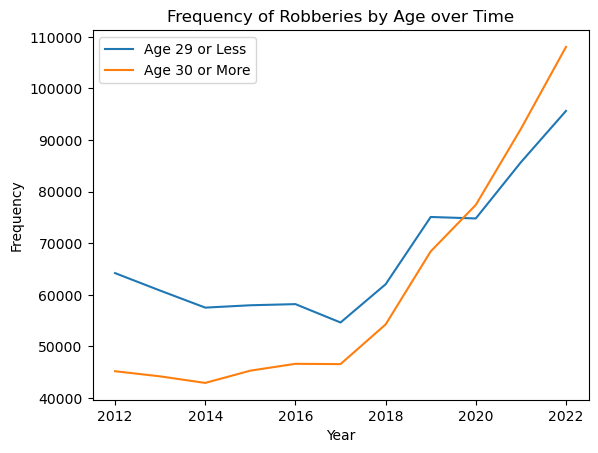

In [35]:
sns.lineplot(x=years, y=list(age_29_or_less.values()), label='Age 29 or Less')
sns.lineplot(x=years, y=list(age_30_plus.values()), label='Age 30 or More')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Robberies by Age over Time')
plt.show()

In [34]:
t_stat, p_value = ttest_ind(
    list(age_30_plus.values()), list(age_29_or_less.values()), alternative='greater')

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

T-Statistic: -0.8707766606491733
P-Value: 0.8028958246288136


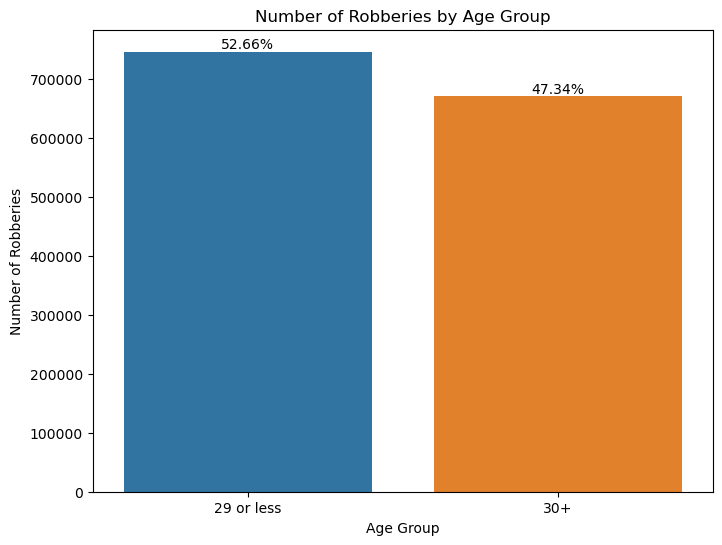

In [72]:
sum_30_plus = sum(list(age_30_plus.values()))
sum_29_or_less = sum(list(age_29_or_less.values()))

total_sum = sum_30_plus + sum_29_or_less

prop_30_plus = sum_30_plus / total_sum
prop_29_or_less = sum_29_or_less / total_sum

data = {
    'Age Group': ['29 or less', '30+'],
    'Actuals': [sum_29_or_less, sum_30_plus],
    'Proportion of Robberies': [prop_29_or_less, prop_30_plus]
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Age Group', y='Actuals', data=df, hue='Age Group')

for state, row in df.iterrows():
    ax.text(state, row['Actuals'] + 5000.0,
            f"{row['Proportion of Robberies']:.2%}", ha='center')

plt.xlabel('Age Group')
plt.ylabel('Number of Robberies')
plt.title('Number of Robberies by Age Group')

plt.show()